# Loading packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [ ]:
#preprocessing LSTM (train-test split, minmaxscaler, validation_set_criteria)
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
#For LSTM architecture
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout #all together

In [ ]:
#for stationarity tests
from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose

#for K-fold cross validation
from sklearn.model_selection import TimeSeriesSplit 

#for output metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error 

In [ ]:
#needed for Emprirical mode decomposition
! pip install EMD-signal
from PyEMD import EMD

In [ ]:
#for hypertuning
from sklearn.model_selection import ParameterGrid

In [ ]:
#model seed with prime numbers
import tensorflow as tf
import random as python_random

def reset_seeds():
   #prime number
   #pas itérer
   np.random.seed(113)
   python_random.seed(113)
   tf.random.set_seed(1151)

# reset_seeds() 

# Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the numpy array from the file "my_array.npy"
adj_close = np.load("/content/drive/MyDrive/adj_close.npy")
sentiment_data = np.load("/content/drive/MyDrive/sentiment_data.npy")

# **Mode decomposition**

In [ ]:
idx = np.arange(len(sentiment_data)) # for the time dimension below

In [ ]:
#Two decomposition techniques. WIll test later if one is leading to better results or not. EMD for the moment is by default and more than enough
Signal = adj_close
T = idx
emd = EMD()
IMFs = emd(Signal)
nIMFs = len(IMFs)


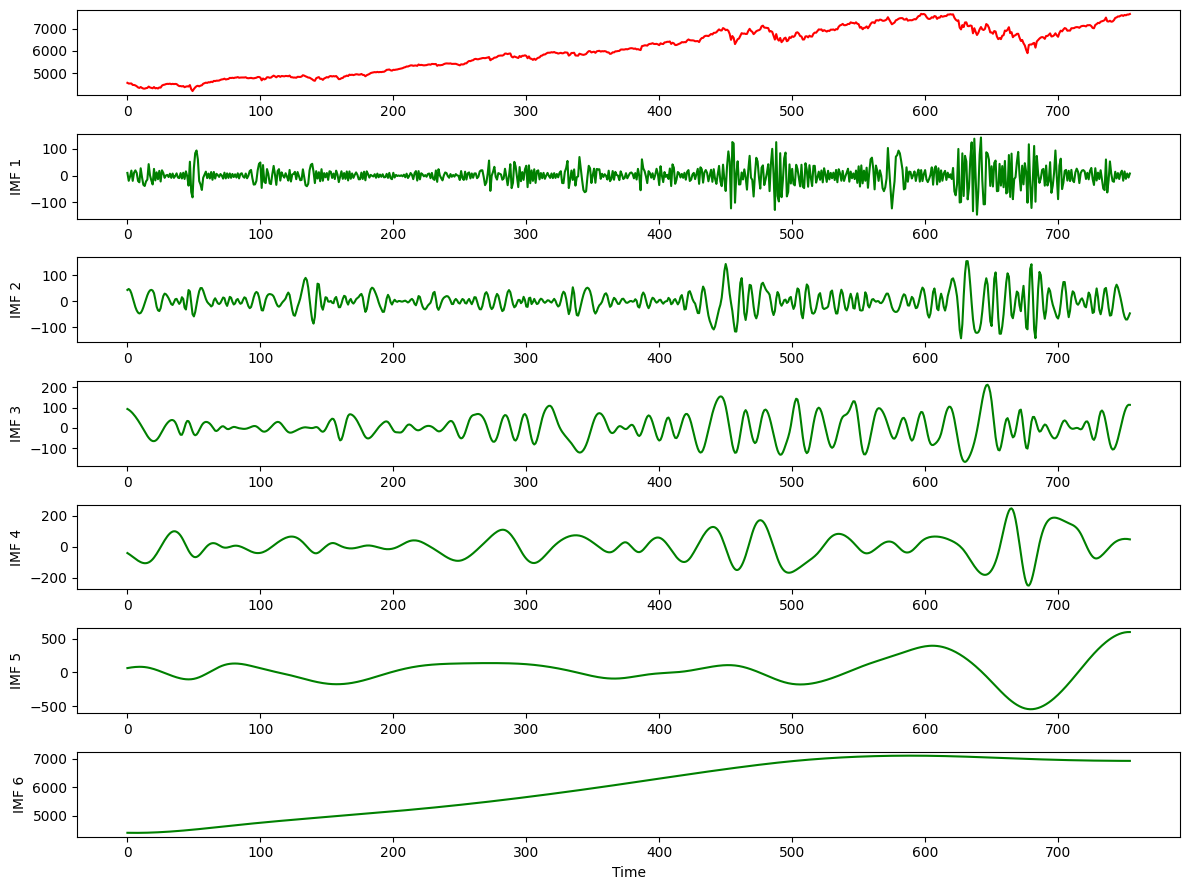

In [ ]:
# Plotting the decomposition (visualise the subsequences getting from the original signal)
plt.figure(figsize=(12,9))
plt.subplot(nIMFs+1, 1, 1)
plt.plot(T, Signal, 'r')

for n in range(nIMFs):
  plt.subplot(nIMFs+1, 1, n+2)
  plt.plot(T, IMFs[n], 'g')
  plt.ylabel("IMF %i" %(n+1))
  plt.locator_params(axis='y', nbins=5)

plt.xlabel("Time")
plt.tight_layout()
plt.show()


# 3. Stacking IMFs in one single LSTM

In [ ]:
# Define the hyperparameters to search over

#only for table
set_up = 3

# not tuning
test_size_split = 0.2

#hyper-parameters
params = {
    'batch_size': [8, 16],
    'num_layers': [1, 2],
    'neurons': [32, 64],
    'epochs': [300], #[100, 200, 300],
    'nmbr_folds': [5,10],
    'news_using': ['yes','no'],
    'lookback_period': [15,30,60]
    # 'attention_layer': ['yes', 'no'] #
}

# Generate the grid of hyperparameters
param_grid = list(ParameterGrid(params))
print('Number of combinations:', len(param_grid))

## Performing LSTM

In [ ]:
# pip install attention

In [ ]:
#modified without zero
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Define the LSTM model
def create_model(neurons, num_layers, lookback,dimension):#attention_layer,
    model = Sequential()
    if num_layers < 2:
      model.add(LSTM(neurons, input_shape=(lookback, dimension)))
    else: # num_layers > 1:
      model.add(LSTM(neurons, input_shape=(lookback, dimension), return_sequences=True))
      model.add(LSTM(neurons))
    # if attention_layer == 'yes':
    #   print('attention')
      # model.add(Attention()) #PROBLEM
    model.add(Dropout(0.1))     

    model.add(Dense(1)) #know which functions are used
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [ ]:
column_names = ['News', 'RMSE', 'MAPE', 'MAE', 'R2', 'Batch_size', 'Initiated_epochs', 'Lookback', 'Num_layers', 'Num_neurons', 'Test_size_split', 'Num_folds', 'Set_up']
results = pd.DataFrame(columns=column_names)

for param_set in param_grid:
    news_using = param_set['news_using']
    batch_size = param_set['batch_size']
    num_layers = param_set['num_layers']
    neurons = param_set['neurons']
    epochs = param_set['epochs']
    nmbr_folds = param_set['nmbr_folds']
    lookback_period = param_set['lookback_period']
    # attention_layer = param_set['attention_layer']

    print(param_set)
    reset_seeds() 
    ## Historical adj_close

    # 1) Reshape adj_close [Y]
    #maybe as float 32
    reshaped_adj_close = np.reshape(adj_close, (-1, 1))
    # 2) Train-test split - I split before Minmax scaling! GREAT
    train_data, test_data = train_test_split(reshaped_adj_close, test_size=test_size_split, shuffle=False)
    # 3) Normalize data
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # 4) lookback_period dataset
    train_X, train_Y = create_dataset(train_data, lookback_period)
    test_X, test_Y = create_dataset(test_data, lookback_period) 

    ## Stacked data [X]

    ##1) scale before splitting but is fine because minmax scaler is used apprpriately

    scaler1 = MinMaxScaler()
    scaler2 = MinMaxScaler()
    scaler3 = MinMaxScaler()
    scaler4 = MinMaxScaler()
    scaler5 = MinMaxScaler()
    scaler6 = MinMaxScaler()

    a = IMFs[0].reshape(-1, 1)
    b = IMFs[1].reshape(-1, 1)
    c = IMFs[2].reshape(-1, 1)
    d = IMFs[3].reshape(-1, 1)
    e = IMFs[4].reshape(-1, 1)
    f = IMFs[5].reshape(-1, 1)

    a = scaler1.fit_transform(a)
    b = scaler2.fit_transform(b)
    c = scaler3.fit_transform(c)
    d = scaler4.fit_transform(d)
    e = scaler5.fit_transform(e)
    f = scaler6.fit_transform(f)

    scaler_sentiment = MinMaxScaler()
    sentiment_data_scaled = sentiment_data.reshape(-1, 1)
    sentiment_data_scaled = scaler_sentiment.fit_transform(sentiment_data_scaled)

    # 1) stack data
    IMFs_stacked = np.column_stack((a,b,c,d,e,f))

    if news_using == 'yes':
      data_stacked = np.column_stack([IMFs_stacked,sentiment_data_scaled])
      second_dimension = data_stacked.shape[1]
    else:
      data_stacked = IMFs_stacked
      second_dimension = data_stacked.shape[1]

    # 2) Train-test split
    train_stacked, test_stacked = train_test_split(data_stacked, test_size=test_size_split, shuffle=False)

    # 4) Create lookback_period dataset
    train_stacked_X, train_stacked_Y = create_dataset(train_stacked, lookback_period)
    test_stacked_X, test_stacked_Y = create_dataset(test_stacked, lookback_period)

    #Create model and compile it (function)  
    model = create_model(neurons=neurons, num_layers=num_layers, lookback=lookback_period, dimension = second_dimension) #, attention_layer=attention_layer

    # Define your TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=nmbr_folds)

    # Define the lists to store the evaluation metrics for each fold
    rmse_list, mae_list, mape_list, r2_list = [], [], [], []

    # Loop through the splits and fit the model
    for train_index, test_index in tscv.split(train_stacked_X):
                
        # Split the data into train and test sets based on the TimeSeriesSplit
        train_stacked_X_fold, test_stacked_X_fold = train_stacked_X[train_index], train_stacked_X[test_index]
        train_Y_fold, test_Y_fold = train_Y[train_index], train_Y[test_index]
        
        #Fit the model
        # model.summary()
        earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min') #Depending on Manon, now only 300 epochs
        model.fit(train_stacked_X_fold, train_Y_fold, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.1, callbacks=[earlystop]) 
        # model.fit(train_stacked_X_fold, train_Y_fold,batch_size=batch_size, epochs=epochs, verbose=0) 
        
        #make predictions of folds blc
        testPredict = model.predict(test_stacked_X_fold)
        predictions = scaler.inverse_transform(testPredict)
        test_Y_fold = scaler.inverse_transform(test_Y_fold)
        # Calculate evaluation metrics and store them in lists
        RMSE = math.sqrt(mean_squared_error(test_Y_fold, predictions))
        MAE = mean_absolute_error(test_Y_fold, predictions)
        price_test_Y_fold_arr = np.array(test_Y_fold)
        predictions_arr = np.array(predictions)
        MAPE = np.mean(np.abs((price_test_Y_fold_arr - predictions_arr) / price_test_Y_fold_arr)) * 100
        R2 = r2_score(test_Y_fold, predictions)
        rmse_list.append(RMSE)
        mae_list.append(MAE)
        mape_list.append(MAPE)
        r2_list.append(R2)
    
    print("Average evaluation metrics across all folds:")
    print("RMSE: {}, MAE: {}, MAPE: {}, R2: {}".format(np.mean(rmse_list), np.mean(mae_list), np.mean(mape_list), np.mean(r2_list)))

    #predictions model on TEST set 
    test_set_predictions = model.predict(test_stacked_X)
    unscaled_test_set_predictions = scaler.inverse_transform(test_set_predictions)
    unscaled_test_Y = scaler.inverse_transform(test_Y)

    #metrics on test set
    RMSE = math.sqrt(mean_squared_error(unscaled_test_Y, unscaled_test_set_predictions))
    MAE = mean_absolute_error(unscaled_test_Y, unscaled_test_set_predictions)
    price_unscaled_test_Y_arr = np.array(unscaled_test_Y)
    unscaled_test_set_predictions_arr = np.array(unscaled_test_set_predictions)
    MAPE = np.mean(np.abs((price_unscaled_test_Y_arr - unscaled_test_set_predictions_arr) / price_unscaled_test_Y_arr)) * 100
    R2 = r2_score(unscaled_test_Y, unscaled_test_set_predictions)

    print("RMSE: {}, MAE: {}, MAPE: {}, R2: {}".format(RMSE, MAE, MAPE, R2))

    row_data = {
    'News': news_using,
    'RMSE': RMSE,
    'MAPE': MAPE,
    'MAE': MAE,
    'R2': R2,
    'Batch_size': batch_size,
    'Initiated_epochs': epochs,
    'Lookback': lookback_period,
    'Num_layers': num_layers,
    'Num_neurons': neurons,
    'Test_size_split': test_size_split,
    'Num_folds': nmbr_folds,
    'Set_up': set_up,
    }
    new_row = pd.DataFrame(row_data, index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

results

In [ ]:
#save df
# from google.colab import drive
# drive.mount('/content/drive')
results.to_csv('/content/drive/My Drive/Colab Notebooks/resultsoutput_3.csv', index=False)

In [ ]:
# Set the figure size and DPI
fig, ax = plt.subplots(figsize=(14, 11), dpi=80)

# Generate the plot lines
x = np.linspace(1, len(unscaled_test_set_predictions) + 1, len(unscaled_test_set_predictions), endpoint=True)
predicted_line, = ax.plot(x, unscaled_test_set_predictions, label="Predicted Value")
actual_line, = ax.plot(x, unscaled_test_Y, label="Actual Value") # or test_Y_fold

# Set the title and axis labels
ax.set_title('Prediction vs. Actual Values')
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add the legend
ax.legend()

# 2. Using different LSTM models for each IMFs


In [ ]:
# Define the hyperparameters to search over

#only for table
set_up = 2

#set-up 2 takes more time which is logic

# not tuning (limitation)
test_size_split = 0.2

#hyper-parameters
params = {
    'batch_size': [8, 16],
    'num_layers': [1, 2],
    'neurons': [32, 64],
    'epochs': [300], #[100, 200, 300],
    'nmbr_folds': [5,10],
    'news_using': ['yes','no'],
        'lookback_period': [15,30,60]
    # 'attention_layer': ['yes', 'no'] #no need put some numbers
}

# Generate the grid of hyperparameters
param_grid = list(ParameterGrid(params))
print('Number of combinations:', len(param_grid))

## Performing LSTM

In [ ]:
# pip install attention #have a thorough look for attention layer!! MOST IMPORTANT

In [ ]:
#modified without zero
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Define the LSTM model
def create_model(neurons, num_layers, lookback,dimension): #attention_layer,
    model = Sequential()
    if num_layers < 2:
      model.add(LSTM(neurons, input_shape=(lookback, dimension)))
    else: # num_layers > 1:
      model.add(LSTM(neurons, input_shape=(lookback, dimension), return_sequences=True))
      model.add(LSTM(neurons))
    # if attention_layer == 'yes':
    #   print('attention')
      # model.add(Attention()) #PROBLEM
    # model.add(Dropout(0.2))     

    model.add(Dense(1)) #know which functions are used
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [ ]:
# Hyperparam

column_names = ['News', 'RMSE', 'MAPE', 'MAE', 'R2', 'Batch_size', 'Initiated_epochs', 'Lookback', 'Num_layers', 'Num_neurons', 'Test_size_split', 'Num_folds', 'Set_up']
results = pd.DataFrame(columns=column_names)

for idx, param_set in enumerate(param_grid):
    print(f"Printing numbers for param_set #{idx+1}:")
    news_using = param_set['news_using']
    batch_size = param_set['batch_size']
    num_layers = param_set['num_layers']
    neurons = param_set['neurons']
    epochs = param_set['epochs']
    nmbr_folds = param_set['nmbr_folds']
    lookback_period = param_set['lookback_period']
    # attention_layer = param_set['attention_layer']

    print(param_set)   

    ## Historical adj_close [Y]

    # 1) Reshape adj_close, another name variable not to influence stacking dimensions below
    #maybe as float 32
    reshaped_adj_close = np.reshape(adj_close, (-1, 1))
    # 2) Train-test split - I split before Minmax scaling! GREAT
    train_data, test_data = train_test_split(reshaped_adj_close, test_size=test_size_split, shuffle=False)
    # 3) Normalize data
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # 4) lookback_period dataset
    train_X, train_Y = create_dataset(train_data, lookback_period)
    test_X, test_Y = create_dataset(test_data, lookback_period) 

    ##Stacked data [X]

    #SCALE sentiment
    scaler_sentiment = MinMaxScaler()
    sentiment_data_scaled = sentiment_data.reshape(-1, 1)
    sentiment_data_scaled = scaler_sentiment.fit_transform(sentiment_data_scaled)

    # 1) stack data
    IMF_predict_list = []
    final_prediction = []
    for imf in IMFs:
      print('next imf')
      scaler_imf = MinMaxScaler()
      imf = imf.reshape(-1, 1)
      imf = scaler_imf.fit_transform(imf)

      if news_using == 'yes':
        data_stacked = np.column_stack([imf,sentiment_data_scaled])
        second_dimension = data_stacked.shape[1]
      else:
        data_stacked = imf
        second_dimension = data_stacked.shape[1]

      # -------------------------------------supervised variable in for imf loop
      # 2) Train-test split
      train_imf, test_imf = train_test_split(imf, test_size=test_size_split, shuffle=False)

      # 4) Create lookback_period dataset
      train_imf_X, train_imf_Y = create_dataset(train_imf, lookback_period)
      test_imf_X, test_imf_Y = create_dataset(test_imf, lookback_period)
      # ------------------------------------------------------------------------

      # 2) Train-test split
      train_stacked, test_stacked = train_test_split(data_stacked, test_size=test_size_split, shuffle=False)

      # 4) Create lookback_period dataset
      train_stacked_X, train_stacked_Y = create_dataset(train_stacked, lookback_period)
      test_stacked_X, test_stacked_Y = create_dataset(test_stacked, lookback_period)
        
      model = create_model(neurons=neurons, num_layers=num_layers, lookback=lookback_period, dimension = second_dimension) #attention_layer=attention_layer,

      # Define your TimeSeriesSplit object
      tscv = TimeSeriesSplit(n_splits=nmbr_folds)

      # Loop through the splits and fit the model
      for train_index, test_index in tscv.split(train_stacked_X):
                
          # Split the data into train and test sets based on the TimeSeriesSplit
          train_stacked_X_fold, test_stacked_X_fold = train_stacked_X[train_index], train_stacked_X[test_index]
          train_imf_Y_fold, test_imf_Y_fold = train_imf_Y[train_index], train_imf_Y[test_index]
          
          # Compile and fit the model
          reset_seeds()
          # model.summary()

          earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min') #Depending on Manon, now only 300 epochs
          model.fit(train_stacked_X_fold, train_imf_Y_fold, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.1, callbacks=[earlystop])

      # predictions model on test set!
      test_set_predictions = model.predict(test_stacked_X)
      unscaled_test_set_predictions = scaler_imf.inverse_transform(test_set_predictions)
      IMF_predict_list.append(unscaled_test_set_predictions) #for adding up

    # This nested for loop is used to generate final prediction by adding up the corresponding values in each subsequence
    for i in range(len(IMF_predict_list[0])):
      element = 0 
      for j in range(len(IMF_predict_list)):
        element += IMF_predict_list[j][i]
      final_prediction = final_prediction + element.tolist()

    unscaled_test_Y = scaler.inverse_transform(test_Y)

    #metrics on test set of dependent variable (after summing up)
    RMSE = math.sqrt(mean_squared_error(final_prediction, unscaled_test_Y))
    MAE = mean_absolute_error(final_prediction, unscaled_test_Y)
    price_final_prediction_arr = np.array(final_prediction)
    unscaled_test_Y_arr = np.array(unscaled_test_Y)
    MAPE = np.mean(np.abs((price_final_prediction_arr - unscaled_test_Y_arr) / price_final_prediction_arr)) * 100
    R2 = r2_score(final_prediction, unscaled_test_Y) 

    print("RMSE: {}, MAE: {}, MAPE: {}, R2: {}".format(RMSE, MAE, MAPE, R2))

    row_data = {
    'News': news_using,
    'RMSE': RMSE,
    'MAPE': MAPE,
    'MAE': MAE,
    'R2': R2,
    'Batch_size': batch_size,
    'Initiated_epochs': epochs,
    'Lookback': lookback_period,
    'Num_layers': num_layers,
    'Num_neurons': neurons,
    'Test_size_split': test_size_split,
    'Num_folds': nmbr_folds,
    'Set_up': set_up,
    }
    new_row = pd.DataFrame(row_data, index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

results

In [ ]:
#save df
# from google.colab import drive
# drive.mount('/content/drive')
results.to_csv('/content/drive/My Drive/Colab Notebooks/Official/Excel/resultsoutput_loop.csv', index=False)

In [ ]:
#save df
# from google.colab import drive
# drive.mount('/content/drive')
# results.to_csv('/content/drive/My Drive/Colab Notebooks/Official/Excel/resultsoutput_loop.csv', index=False)

# 1. No EMD

In [ ]:
# Define the hyperparameters to search over
set_up = 1
test_size_split = 0.2

#hyper-parameters
params = {
    'batch_size': [8, 16],
    'num_layers': [1, 2],
    'neurons': [32, 64],
    'epochs': [300], #[100, 200, 300],
    'nmbr_folds': [5,10],
    'news_using': ['yes','no'],
    'lookback_period': [15,30,60]
    # 'attention_layer': ['yes', 'no'] #no need put some numbers
}

# Generate the grid of hyperparameters
param_grid = list(ParameterGrid(params))
print('Number of combinations:', len(param_grid))

## Performing LSTM

In [ ]:
#modified without zero
def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Define the LSTM model
def create_model(neurons, num_layers, lookback,dimension):#attention_layer,
    model = Sequential()
    if num_layers < 2:
      model.add(LSTM(neurons, input_shape=(lookback, dimension)))
    else: # num_layers > 1:
      model.add(LSTM(neurons, input_shape=(lookback, dimension), return_sequences=True))
      model.add(LSTM(neurons))
    # if attention_layer == 'yes':
    #   print('attention')
      # model.add(Attention())
    model.add(Dropout(0.1))     

    model.add(Dense(1)) 
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

In [ ]:
column_names = ['News', 'RMSE', 'MAPE', 'MAE', 'R2', 'Batch_size', 'Initiated_epochs', 'Lookback', 'Num_layers', 'Num_neurons', 'Test_size_split', 'Num_folds', 'Set_up']
results = pd.DataFrame(columns=column_names)

for idx, param_set in enumerate(param_grid):
    print(f"Printing numbers for param_set #{idx+1}:")
    news_using = param_set['news_using']
    batch_size = param_set['batch_size']
    num_layers = param_set['num_layers']
    neurons = param_set['neurons']
    epochs = param_set['epochs']
    nmbr_folds = param_set['nmbr_folds']
    lookback_period = param_set['lookback_period']
    # attention_layer = param_set['attention_layer']
    print(param_set)

    ## Historical price [Y]

    # 1) Reshape price, another name variable not to influence stacking dimensions below
    #maybe as float 32
    reshaped_price = np.reshape(adj_close, (-1, 1))
    # 2) Train-test split - I split before Minmax scaling! GREAT
    train_data, test_data = train_test_split(reshaped_price, test_size=test_size_split, shuffle=False)
    # 3) Normalize data
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    # 4) lookback_period dataset
    train_X, train_Y = create_dataset(train_data, lookback_period)
    test_X, test_Y = create_dataset(test_data, lookback_period) 

    ##Stacked data [X]

    # scaler here more correct and does not change anything
    scaler_sentiment = MinMaxScaler()
    sentiment_data_scaled = sentiment_data.reshape(-1, 1)
    sentiment_data_scaled = scaler_sentiment.fit_transform(sentiment_data_scaled)

    scaler_price = MinMaxScaler()
    adj_close_scaled = adj_close.reshape(-1, 1)
    adj_close_scaled = scaler_price.fit_transform(adj_close_scaled)

    # 1) stack data
    if news_using == 'yes':
      data_stacked = np.column_stack([adj_close_scaled,sentiment_data_scaled])
      second_dimension = data_stacked.shape[1]
    else:
      data_stacked = np.column_stack([adj_close_scaled])
      second_dimension = data_stacked.shape[1]  

    # 2) Train-test split
    train_stacked, test_stacked = train_test_split(data_stacked, test_size=test_size_split, shuffle=False)

    # 4) Create lookback_period dataset
    train_stacked_X, train_stacked_Y = create_dataset(train_stacked, lookback_period)
    test_stacked_X, test_stacked_Y = create_dataset(test_stacked, lookback_period)

    # Define your LSTM model
    reset_seeds()
    model = create_model(neurons=neurons, num_layers=num_layers, lookback=lookback_period, dimension = second_dimension) #attention_layer=attention_layer,

    # Define your TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=nmbr_folds)

    # Loop through the splits and fit the model
    for train_index, test_index in tscv.split(train_stacked_X):
        
        # Split the data into train and test sets based on the TimeSeriesSplit
        train_stacked_X_fold, test_stacked_X_fold = train_stacked_X[train_index], train_stacked_X[test_index]
        train_Y_fold, test_Y_fold = train_Y[train_index], train_Y[test_index]
        
        # fit the model
        #model.summary
        earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='min') 
        model.fit(train_stacked_X_fold, train_Y_fold, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1, callbacks=[earlystop])

    #predictions model on test set 
    test_set_predictions = model.predict(test_stacked_X)
    unscaled_test_set_predictions = scaler.inverse_transform(test_set_predictions)
    unscaled_test_Y = scaler.inverse_transform(test_Y)

    #metrics on test set
    RMSE = math.sqrt(mean_squared_error(unscaled_test_Y, unscaled_test_set_predictions))
    MAE = mean_absolute_error(unscaled_test_Y, unscaled_test_set_predictions)
    price_unscaled_test_Y_arr = np.array(unscaled_test_Y)
    unscaled_test_set_predictions_arr = np.array(unscaled_test_set_predictions)
    MAPE = np.mean(np.abs((price_unscaled_test_Y_arr - unscaled_test_set_predictions_arr) / price_unscaled_test_Y_arr)) * 100
    R2 = r2_score(unscaled_test_Y, unscaled_test_set_predictions)

    print("RMSE: {}, MAE: {}, MAPE: {}, R2: {}".format(RMSE, MAE, MAPE, R2))

    row_data = {
    'News': news_using,
    'RMSE': RMSE,
    'MAPE': MAPE,
    'MAE': MAE,
    'R2': R2,
    'Batch_size': batch_size,
    'Initiated_epochs': epochs,
    'Lookback': lookback_period,
    'Num_layers': num_layers,
    'Num_neurons': neurons,
    'Test_size_split': test_size_split,
    'Num_folds': nmbr_folds,
    'Set_up': set_up,
    }
    new_row = pd.DataFrame(row_data, index=[0])
    results = pd.concat([results, new_row], ignore_index=True)

In [ ]:
#save df
# from google.colab import drive
# drive.mount('/content/drive')
results.to_csv('/content/drive/My Drive/Colab Notebooks/Official/Excel/resultsoutput_1.csv', index=False)

In [ ]:
# Set the figure size and DPI
fig, ax = plt.subplots(figsize=(14, 11), dpi=80)

# Generate the plot lines
x = np.linspace(1, len(unscaled_test_set_predictions) + 1, len(unscaled_test_set_predictions), endpoint=True)
predicted_line, = ax.plot(x, unscaled_test_set_predictions, label="Predicted Value")
actual_line, = ax.plot(x, unscaled_test_Y, label="Actual Value") # or test_Y_fold

# Set the title and axis labels
ax.set_title('Prediction vs. Actual Values')
ax.set_xlabel('Time')
ax.set_ylabel('Value')

# Add the legend
ax.legend()